<a href="https://colab.research.google.com/github/c4bath/cf860/blob/main/APTOS_CLAHE_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

File Details

Function: Apply Contrast Limited AHE (CLAHE) to the APTOS images and save as new image files and numpy arrays for training, validation and testing








In [ ]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
'''
try:
    import scikeras
except ImportError:
    !python -m pip install scikeras

'''

'\ntry:\n    import scikeras\nexcept ImportError:\n    !python -m pip install scikeras\n\n'

In [ ]:
import warnings
from tensorflow import get_logger
get_logger().setLevel('ERROR')
warnings.filterwarnings("ignore", message="Setting the random state for TF")

In [ ]:
#!pip install -q -U keras-tuner


In [ ]:
import numpy as np
import os
import pandas as pd

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

import PIL
import plotly
import plotly.graph_objs as go

import seaborn as sns

import tensorflow as tf

from IPython.display import display

from keras import layers
from keras import models
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Sequential
from PIL import Image

import cv2

from plotly.offline import iplot, init_notebook_mode
#from scikeras.wrappers import KerasClassifier, KerasRegressor

from sklearn.metrics import cohen_kappa_score, matthews_corrcoef
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import scipy
from tqdm import tqdm

from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.activations import swish
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model
#import keras_tuner as kt


In [ ]:
# To have reproducible results
seed = 27

np.random.seed(seed)

tf.random.set_seed(seed)

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
# Check the number of images in the dataset
train = []
label = []

# os.listdir returns the list of files in the folder, in this case image class names
for i in os.listdir('/content/drive/MyDrive/cfPublicData/aptos2/main_aptos'):
  train_class = os.listdir(os.path.join('/content/drive/MyDrive/cfPublicData/aptos2/main_aptos', i))
  for j in train_class:
    img = os.path.join('/content/drive/MyDrive/cfPublicData/aptos2/main_aptos', i, j)
    train.append(img)
    label.append(i)

print('Number of train images : {} \n'.format(len(train)))

Number of train images : 3662 



In [ ]:
# check the number of images in each class in the training dataset

No_images_per_class = []
Class_name = []
for i in os.listdir('/content/drive/MyDrive/cfPublicData/aptos2/main_aptos'):
  train_class = os.listdir(os.path.join('/content/drive/MyDrive/cfPublicData/aptos2/main_aptos', i))
  No_images_per_class.append(len(train_class))
  Class_name.append(i)
  print('Number of images in {} = {} \n'.format(i, len(train_class)))

Number of images in Moderate = 999 

Number of images in Mild = 370 

Number of images in Severe = 193 

Number of images in No_DR = 1805 

Number of images in Proliferative_DR = 295 



In [ ]:
retina_df = pd.DataFrame({'Image': train,'Labels': label})
retina_df

In [ ]:
# Create a smallsubset for experiments

_, smallret_df = train_test_split(retina_df, test_size=0.5, stratify=retina_df['Labels'], random_state=27)
smallret_df


,Image,Labels
3335,/content/drive/MyDrive/cfPublicData/aptos2/mai...,No_DR
3528,/content/drive/MyDrive/cfPublicData/aptos2/mai...,Proliferative_DR
2871,/content/drive/MyDrive/cfPublicData/aptos2/mai...,No_DR
2998,/content/drive/MyDrive/cfPublicData/aptos2/mai...,No_DR
2087,/content/drive/MyDrive/cfPublicData/aptos2/mai...,No_DR
...,...,...
251,/content/drive/MyDrive/cfPublicData/aptos2/mai...,Moderate
2462,/content/drive/MyDrive/cfPublicData/aptos2/mai...,No_DR
1700,/content/drive/MyDrive/cfPublicData/aptos2/mai...,No_DR
2427,/content/drive/MyDrive/cfPublicData/aptos2/mai...,No_DR


Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


In [ ]:
# Shuffle the data and split it into training and testing
retina_df = shuffle(retina_df)
#train, test = train_test_split(retina_df, test_size =0.3, stratify=smallret_df['Labels'], random_state=27)

In [ ]:
IMG_SIZE=224

In [ ]:
def preprocess_image(path, sigmaX=10):
    img = cv2.imread(path)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Apply CLAHE
    img_lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(img_lab)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    l_clahe = clahe.apply(l)
    limg = cv2.merge([l_clahe, a, b])
    img = cv2.cvtColor(limg, cv2.COLOR_LAB2RGB)

    return img

In [ ]:
# Select a small number of rows for testing
test_train_df = train_df.head(5)
test_test_df = test_df.head(5)
test_valid_df = valid_df.head(5)


In [ ]:

def process_and_save_images(df, split):
    for _, row in tqdm(df.iterrows(), total=len(df)):
        image_path = row['Image']  # Use the full path directly from the DataFrame
        try:
            processed_img = preprocess_image(image_path)
            save_path = os.path.join(dest_dir, split, row['Labels'], os.path.basename(image_path))
            cv2.imwrite(save_path, cv2.cvtColor(processed_img, cv2.COLOR_RGB2BGR))
        except Exception as e:
            print(f"Error processing {image_path}: {e}")

# Process and save images
process_and_save_images(train_df, 'train')
process_and_save_images(test_df, 'test')
process_and_save_images(valid_df, 'valid')



100%|██████████| 550/550 [00:11<00:00, 48.73it/s]


In [ ]:
# Assuming retina_df is your DataFrame with 'Image' and 'Labels' columns
source_dir = '/content/drive/MyDrive/cfPublicData/aptos2/main_aptos'
dest_dir = '/content/drive/MyDrive/aptos224'
classes = ['Moderate', 'Mild', 'Severe', 'No_DR', 'Proliferative_DR']

# Create train, test, and valid directories
for split in ['train', 'test', 'valid']:
    for cls in classes:
        os.makedirs(os.path.join(dest_dir, split, cls), exist_ok=True)

# Perform stratified split
train_df, test_df = train_test_split(retina_df, test_size=0.3, stratify=retina_df['Labels'], random_state=27)
test_df, valid_df = train_test_split(test_df, test_size=0.5, stratify=test_df['Labels'], random_state=27)

# Define a function to process and save images
def process_and_save_images(df, split):
    for _, row in tqdm(df.iterrows(), total=len(df)):
        image_path = os.path.join(source_dir, row['Image'])
        try:
            processed_img = preprocess_image(image_path)
            save_path = os.path.join(dest_dir, split, row['Labels'], row['Image'])
            cv2.imwrite(save_path, cv2.cvtColor(processed_img, cv2.COLOR_RGB2BGR))
        except Exception as e:
            print(f"Error processing {image_path}: {e}")

# Process and save images
process_and_save_images(train_df, 'train')
process_and_save_images(test_df, 'test')
process_and_save_images(valid_df, 'valid')


100%|██████████| 550/550 [05:56<00:00,  1.54it/s]


In [ ]:
import os
import shutil

dest_dir = '/content/drive/MyDrive/aptos224'
splits = ['train', 'test', 'valid']
classes = ['Moderate', 'Mild', 'Severe', 'No_DR', 'Proliferative_DR']



In [ ]:
n = 5  # Number of files to delete from each directory

for split in splits:
    for cls in classes:
        folder_path = os.path.join(dest_dir, split, cls)
        files = os.listdir(folder_path)
        for file in files[:n]:  # Delete only the first n files
            file_path = os.path.join(folder_path, file)
            try:
                os.remove(file_path)
                print(f"Deleted {file_path}")
            except Exception as e:
                print(f"Error deleting {file_path}: {e}")


Deleted /content/drive/MyDrive/aptos224/train/Moderate/bc23f74e14dd.png
Deleted /content/drive/MyDrive/aptos224/train/Mild/4393c5bc576a.png
Deleted /content/drive/MyDrive/aptos224/train/Mild/2f2e1949ad56.png
Deleted /content/drive/MyDrive/aptos224/train/No_DR/7fe7309d0b4f.png
Deleted /content/drive/MyDrive/aptos224/train/Proliferative_DR/de16416220de.png
Deleted /content/drive/MyDrive/aptos224/test/Moderate/ea4dcb055139.png
Deleted /content/drive/MyDrive/aptos224/test/Moderate/6987804eb464.png
Deleted /content/drive/MyDrive/aptos224/test/Moderate/c3e02d4a1798.png
Deleted /content/drive/MyDrive/aptos224/test/Mild/77a9538b8362.png
Deleted /content/drive/MyDrive/aptos224/test/Proliferative_DR/0bf37ca3156a.png
Deleted /content/drive/MyDrive/aptos224/valid/No_DR/1cc58b15f466.png
Deleted /content/drive/MyDrive/aptos224/valid/No_DR/bf7221a016b5.png
Deleted /content/drive/MyDrive/aptos224/valid/No_DR/0cbcc7b23613.png
Deleted /content/drive/MyDrive/aptos224/valid/No_DR/ea6a53e54d0f.png
Deleted 

In [ ]:


dest_dir = '/content/drive/MyDrive/aptos224'
splits = ['train', 'test', 'valid']
classes = ['Moderate', 'Mild', 'Severe', 'No_DR', 'Proliferative_DR']

for split in splits:
    for cls in classes:
        folder_path = os.path.join(dest_dir, split, cls)
        num_files = len([name for name in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, name))])
        print(f"Number of files in {folder_path}: {num_files}")


Number of files in /content/drive/MyDrive/aptos224/train/Moderate: 699
Number of files in /content/drive/MyDrive/aptos224/train/Mild: 259
Number of files in /content/drive/MyDrive/aptos224/train/Severe: 135
Number of files in /content/drive/MyDrive/aptos224/train/No_DR: 1263
Number of files in /content/drive/MyDrive/aptos224/train/Proliferative_DR: 207
Number of files in /content/drive/MyDrive/aptos224/test/Moderate: 150
Number of files in /content/drive/MyDrive/aptos224/test/Mild: 55
Number of files in /content/drive/MyDrive/aptos224/test/Severe: 29
Number of files in /content/drive/MyDrive/aptos224/test/No_DR: 271
Number of files in /content/drive/MyDrive/aptos224/test/Proliferative_DR: 44
Number of files in /content/drive/MyDrive/aptos224/valid/Moderate: 150
Number of files in /content/drive/MyDrive/aptos224/valid/Mild: 56
Number of files in /content/drive/MyDrive/aptos224/valid/Severe: 29
Number of files in /content/drive/MyDrive/aptos224/valid/No_DR: 271
Number of files in /conten

In [ ]:
print(test.shape)
print(train.shape)

(550, 2)
(1281, 2)


In [ ]:
N = train.shape[0]
x_train = np.empty((N, IMG_SIZE, IMG_SIZE, 3), dtype=np.uint8)

for i, image_path in enumerate(tqdm(train['Image'])):
    x_train[i, :, :, :] = preprocess_image(image_path)


100%|██████████| 1281/1281 [10:59<00:00,  1.94it/s]


In [ ]:
N = test.shape[0]
x_test = np.empty((N, IMG_SIZE, IMG_SIZE, 3), dtype=np.uint8)

for i, image_path in enumerate(tqdm(test['Image'])):
    x_test[i, :, :, :] = preprocess_image(image_path)

100%|██████████| 550/550 [04:36<00:00,  1.99it/s]


In [ ]:
# Assuming x_train is your ndarray
# Replace 'path_to_your_directory' with the actual path in your Google Drive
np.save('/content/drive/MyDrive/cfPublicData/aptos2/arrays/224/x_train.npy', x_train)
np.save('/content/drive/MyDrive/cfPublicData/aptos2/arrays/224/x_test.npy', x_test)


In [ ]:
#original
'''
N = smallret_df.shape[0]
x_train = np.empty((N, IMG_SIZE, IMG_SIZE, 3), dtype=np.uint8)

for i, image_path in enumerate(tqdm(smallret_df['Image'])):
    x_train[i, :, :, :] = preprocess_image(image_path)
'''

"\nN = smallret_df.shape[0]\nx_train = np.empty((N, IMG_SIZE, IMG_SIZE, 3), dtype=np.uint8)\n\nfor i, image_path in enumerate(tqdm(smallret_df['Image'])):\n    x_train[i, :, :, :] = preprocess_image(image_path)\n"

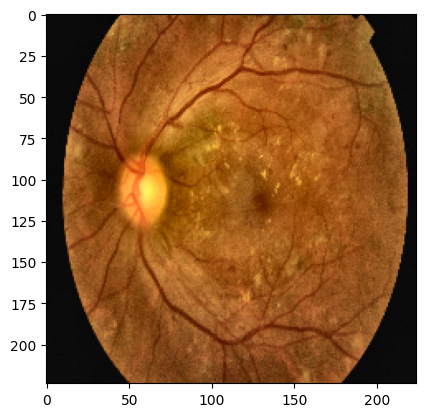

In [ ]:
plt.imshow(x_train[1])
plt.show()

In [ ]:
#print(x_test.shape)

In [ ]:
#x_train[:3]

In [ ]:
#print(y_train.shape)

In [ ]:
#print(len(x_train), len(y_train))


In [ ]:
#print(x_train.shape)
#print(y_train.shape)

In [ ]:
y_train=train['Labels']
y_test=test['Labels']



In [ ]:
np.save('/content/drive/MyDrive/cfPublicData/aptos2/arrays/224/y_train.npy', y_train)
np.save('/content/drive/MyDrive/cfPublicData/aptos2/arrays/224/y_test.npy', y_test)

In [ ]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Initialize the label encoder
label_encoder = LabelEncoder()

# Fit label encoder and return encoded labels
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.fit_transform(y_test)

# Number of classes
num_classes = len(label_encoder.classes_)

# Convert labels to one-hot encoding
y_train_categorical = to_categorical(y_train_encoded, num_classes=num_classes)
y_test_categorical = to_categorical(y_test_encoded, num_classes=num_classes)

In [ ]:
np.save('/content/drive/MyDrive/cfPublicData/aptos2/arrays/224/y_train_categorical.npy', y_train_categorical)
np.save('/content/drive/MyDrive/cfPublicData/aptos2/arrays/224/y_test_categorical.npy', y_test_categorical)

In [ ]:
y_test_categorical.shape

(550, 5)

In [ ]:
'''
x_train, x_test, y_train_categorical, y_test = train_test_split(
    x_train, y_train_categorical,
    test_size=0.2,
    random_state=27
)
'''

In [ ]:
'''
datagen =  ImageDataGenerator(
        zoom_range=0.6,  # set range for random zoom, changed from 0.15 to 0.3, now changed from 0.3 to 0.45, from 0.45 to 0.6
        # set mode for filling points outside the input boundaries
        fill_mode='constant',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,# randomly flip images
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        rescale=1./255
        validation_split = 0.2
    )
# Normalize test data
test_datagen = ImageDataGenerator(rescale = 1./255)
'''

In [ ]:
# Splitting the data - create validation set
x_train1, x_val, y_train1, y_val = train_test_split(
    x_train, y_train_categorical, test_size=0.1, random_state=27, stratify=y_train_categorical
)

# Creating ImageDataGenerator
train_datagen =  ImageDataGenerator(
        zoom_range=0.6,  # set range for random zoom, changed from 0.15 to 0.3, now changed from 0.3 to 0.45, from 0.45 to 0.6
        # set mode for filling points outside the input boundaries
        fill_mode='constant',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,# randomly flip images
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        rescale=1./255,
    )

val_datagen =  ImageDataGenerator(rescale=1./255)

#test_datagen =  ImageDataGenerator(rescale=1./255)

# Creating train and validation generators
train_generator = train_datagen.flow(x_train1, y_train1, batch_size=BATCH_SIZE, seed=27)

val_generator = val_datagen.flow(x_val, y_val, batch_size=BATCH_SIZE, seed=27)
#test_generator = test_datagen(x_test, y_test_categorical, batch_size=BATCH_SIZE, seed=27)



In [ ]:
print(x_train.shape)
print(y_train_categorical.shape)

(1281, 224, 224, 3)
(1281, 5)


In [ ]:
val_datagen =  ImageDataGenerator(rescale=1./255)

test_datagen =  ImageDataGenerator(rescale=1./255)

val_generator = val_datagen.flow(x_train, y_train_categorical, batch_size=BATCH_SIZE, seed=27, subset='validation')
test_generator = test_datagen(x_test, y_test, batch_size=BATCH_SIZE, seed=27)


In [ ]:
test_datagen = ImageDataGenerator(...)  # If preprocessing needed for test data

test_generator = test_datagen.flow(x_test, y_test, batch_size=BATCH_SIZE, seed=27)


In [ ]:
'''
# Fetch a single batch from the generator
batch = next(data_generator)

# Unpack the batch into inputs (features) and outputs (labels)
inputs, outputs = batch

# Print the shapes
print("Input shape:", inputs.shape)
print("Output shape:", outputs.shape)
'''

In [ ]:
#outputs